# LSTM 써보기    
이것은 모두의연구소 AIFFEL 부산2기 아이펠톤 팀 레드존의 이창현이 센서 데이터를 LSTM으로 학습시켜 보려고 하는 노트북입니다.  
일단 라벨링 방식에 따라 두 데이터레이블을 병합할 필요가 있습니다. 근데 하나로 일단 돌려도 괜찮습니다.  
LSTM은 시퀀스에 대한 것으로, 여기서는 시계열 데이터를 쓰고 있으므로 그걸 특정 길이로 잘라 쓰도록 합니다. 그렇다면 결측치는 어떻게 처리할까요? 일단 linear하게 interpolation을 하도록 합니다.  

# 업데이트 로그
2022-11-07 11:44 디버깅 및 missing value 처리 완료. sequence로 전환 작업중...
2022-11-04 16:20 class Lin_Interpolate 디버깅중... -> datetime이나, timestamp 너무 애매합니다. 그냥 앞으로는 YYYY, MM, DD, HH integer 4개로 통일합니다.

## 일시 처리 방법:
이 노트북에서는 날짜+시간까지 int로 전환하여 처리합니다.
시간 연산 할 때에는 pd.Timestamp로 입력하고, 다시 데이터프레임에서는 integer를 둡니다.
```python
#convert between pandas.Timestamp <-> integers
a=pd.Timestamp(2019, 1, 1)
print(a, type(a), a.year, a.month, a.day, a.hour, type(a.year))

#add 1 hour
a=pd.Timestamp(2019, 1, 1)
a+pd.Timedelta(1, 'h')
```

In [12]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [26]:
ds = pd.read_csv('data/17-19실측(예찰선)labeled.csv', encoding='euc-kr')

In [27]:
print(ds['일시'].dtype, type(ds['일시'].values[0]))

object <class 'str'>


In [28]:
ds['year']=ds['일시'].apply(lambda x: pd.Timestamp(x).year)
ds['mm']=ds['일시'].apply(lambda x: pd.Timestamp(x).month)
ds['dd']=ds['일시'].apply(lambda x: pd.Timestamp(x).day)
ds['hh']=ds['일시'].apply(lambda x: pd.Timestamp(x).hour)

In [29]:
ds

,Unnamed: 0,지점,일시,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생,year,mm,dd,hh
0,0,추자도,2017-01-01 1:00,4.2,306.0,11.0,15.8,0.0,0,2017,1,1,1
1,1,추자도,2017-01-01 2:00,2.6,315.0,10.8,15.7,0.0,0,2017,1,1,2
2,2,추자도,2017-01-01 3:00,2.5,307.0,10.8,15.6,0.0,0,2017,1,1,3
3,3,추자도,2017-01-01 4:00,1.5,331.0,11.0,15.6,0.0,0,2017,1,1,4
4,4,추자도,2017-01-01 5:00,4.2,331.0,10.8,15.6,0.0,0,2017,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123974,123974,통영,2019-12-30 20:00,10.7,306.0,12.2,13.9,0.0,0,2019,12,30,20
123975,123975,통영,2019-12-30 21:00,11.3,298.0,11.3,13.8,0.0,0,2019,12,30,21
123976,123976,통영,2019-12-30 22:00,11.9,291.0,10.3,13.6,0.0,0,2019,12,30,22
123977,123977,통영,2019-12-30 23:00,14.9,296.0,8.9,13.5,0.0,0,2019,12,30,23


# 1. 전처리

## 결측치 missing values
일단 linear interpolation을 하도록 합니다. 메모리가 크지 않기 때문에 데이터셋을 포함하는 그 어떤 클래스를 만들어서 쓰겠습니다.  
그 전에, 연속적으로 빠진 일시를 파악합니다.

In [64]:
ds0=ds.loc[ds['지점']=='통영']
ds0

,Unnamed: 0,지점,일시,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생,year,mm,dd,hh
99918,99918,통영,2017-01-01 1:00,NaN,NaN,8.8,17.5,0.0,0,2017,1,1,1
99919,99919,통영,2017-01-01 2:00,NaN,NaN,8.8,17.5,0.0,0,2017,1,1,2
99920,99920,통영,2017-01-01 3:00,NaN,NaN,9.1,17.5,0.0,0,2017,1,1,3
99921,99921,통영,2017-01-01 4:00,NaN,NaN,9.1,17.4,0.0,0,2017,1,1,4
99922,99922,통영,2017-01-01 5:00,NaN,NaN,8.5,17.4,0.0,0,2017,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123974,123974,통영,2019-12-30 20:00,10.7,306.0,12.2,13.9,0.0,0,2019,12,30,20
123975,123975,통영,2019-12-30 21:00,11.3,298.0,11.3,13.8,0.0,0,2019,12,30,21
123976,123976,통영,2019-12-30 22:00,11.9,291.0,10.3,13.6,0.0,0,2019,12,30,22
123977,123977,통영,2019-12-30 23:00,14.9,296.0,8.9,13.5,0.0,0,2019,12,30,23


In [65]:
ds0.reset_index(inplace=True)
df_default_index=['지점',  'year', 'mm', 'dd', 'hh', '풍속(m/s)', '풍향(deg)', '기온(°C)', '수온(°C)', '강수량(mm)', '적조발생']
ds0=ds0[df_default_index]
ds0

,지점,year,mm,dd,hh,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생
0,통영,2017,1,1,1,NaN,NaN,8.8,17.5,0.0,0
1,통영,2017,1,1,2,NaN,NaN,8.8,17.5,0.0,0
2,통영,2017,1,1,3,NaN,NaN,9.1,17.5,0.0,0
3,통영,2017,1,1,4,NaN,NaN,9.1,17.4,0.0,0
4,통영,2017,1,1,5,NaN,NaN,8.5,17.4,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
24056,통영,2019,12,30,20,10.7,306.0,12.2,13.9,0.0,0
24057,통영,2019,12,30,21,11.3,298.0,11.3,13.8,0.0,0
24058,통영,2019,12,30,22,11.9,291.0,10.3,13.6,0.0,0
24059,통영,2019,12,30,23,14.9,296.0,8.9,13.5,0.0,0


In [66]:
dt_index=['year', 'mm', 'dd', 'hh']

class Lin_Interpolate:
    """Linear interpolate nan datetimes
    """
    def __init__(self, dataframe):
        """receive 'datetime dateframe'. It should include
        yyyy, mm, dd, hh as columns of which type is int64"""
        self.dtd=dataframe
        self.time_start=self.dtd[dt_index].loc[0].to_numpy()
        self.time_end=self.dtd[dt_index].loc[len(self.dtd)-1].to_numpy()
    
    def check_sorted(self):
        #return (self.dtd.sort_values(by=dt_index,ascending=True) == self.dtd).all()
        if (self.dtd.sort_values(by=dt_index,ascending=True)['dd'] == self.dtd['dd']).all() \
            and (self.dtd.sort_values(by=dt_index,ascending=True)['year'] == self.dtd['year']).all()\
            and (self.dtd.sort_values(by=dt_index,ascending=True)['mm'] == self.dtd['mm']).all():
            return True
        else:
            return False
    def next_hour(self, array):
        '''def next_day(self, array)
        return next day as numpy ndarray.
        '''
        next_hour=pd.Timestamp(*array)+pd.Timedelta(1, 'h')
        return np.array([next_hour.year, next_hour.month, next_hour.day, next_hour.hour])
        
    
    def missing_hours(self, t0, t1):
        t=t0
        missing_hours_list=[]
        missing_hours_number=0
        missing_hours_df=pd.DataFrame()

        for idx in range(len(self.dtd)):
            target_date=self.dtd.loc[idx][dt_index].astype(int).values
            while pd.Timestamp(*t)<=pd.Timestamp(*target_date):
                if (t==target_date).all():
                    t=self.next_hour(t)
                else:
                    missing_hours_list.append(t)
                    t=self.next_hour(t)
                    missing_hours_number+=1
        print('total {} missing hours found'.format(missing_hours_number))
        
        return pd.DataFrame(missing_hours_list, columns=dt_index)

    def fill_hours(self, target_df):
        return pd.concat([target_df, self.missing_hours(self.time_start, self.time_end)])
    
#ds0=ds.loc[ds['지점']=='추자도']

lin_interpolate=Lin_Interpolate(ds0)
lin_interpolate.check_sorted()

True

## validation
약 3년은 $365 \times 24 \times 3=26280$시간이므로, 이와 비슷한 수가 나와야 한다.

In [67]:
print(len(ds0))
ds0=lin_interpolate.fill_hours(ds0)
print(len(ds0))

24061
total 2195 missing hours found
26256


## interpolate 등
- 시간에 대해 sort하고 index, column등을 정리합니다.
- linear interpolate하고, 
- linear interpolate로 채워지지 않는 '지점' 등을 채워 넣고
- 결측치가 있는 row를 제거합니다. (interpolate는 데이터포인트 사이만 채우기 때문에, 시작이나 끝 부분의 결측치는 사라지지 않습니다.)

In [68]:
df_default_index=['지점',  'year', 'mm', 'dd', 'hh', '풍속(m/s)', '풍향(deg)', '기온(°C)', '수온(°C)', '강수량(mm)', '적조발생']

#reset index
ds0.sort_values(by=dt_index, inplace=True)
ds0.reset_index(inplace=True, drop=True) #'if drop'=True, drop current index. if False, it becomes a new column.
ds0=ds0[df_default_index]

ds0

,지점,year,mm,dd,hh,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생
0,통영,2017,1,1,1,NaN,NaN,8.8,17.5,0.0,0.0
1,통영,2017,1,1,2,NaN,NaN,8.8,17.5,0.0,0.0
2,통영,2017,1,1,3,NaN,NaN,9.1,17.5,0.0,0.0
3,통영,2017,1,1,4,NaN,NaN,9.1,17.4,0.0,0.0
4,통영,2017,1,1,5,NaN,NaN,8.5,17.4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
26251,통영,2019,12,30,20,10.7,306.0,12.2,13.9,0.0,0.0
26252,통영,2019,12,30,21,11.3,298.0,11.3,13.8,0.0,0.0
26253,통영,2019,12,30,22,11.9,291.0,10.3,13.6,0.0,0.0
26254,통영,2019,12,30,23,14.9,296.0,8.9,13.5,0.0,0.0


통영 50까지의 데이터는 두 케이스(interpolate가 되는 경우와 되지 않는 경우)의 결측치가 모두 있습니다.

In [69]:
print(ds0[:50])

     지점  year  mm  dd  hh  풍속(m/s)  풍향(deg)  기온(°C)  수온(°C)  강수량(mm)  적조발생
0    통영  2017   1   1   1      NaN      NaN     8.8    17.5      0.0   0.0
1    통영  2017   1   1   2      NaN      NaN     8.8    17.5      0.0   0.0
2    통영  2017   1   1   3      NaN      NaN     9.1    17.5      0.0   0.0
3    통영  2017   1   1   4      NaN      NaN     9.1    17.4      0.0   0.0
4    통영  2017   1   1   5      NaN      NaN     8.5    17.4      0.0   0.0
5    통영  2017   1   1   6      NaN      NaN     8.4    17.3      0.0   0.0
6    통영  2017   1   1   7      NaN      NaN     8.4    17.3      0.0   0.0
7    통영  2017   1   1   8      NaN      NaN     8.2    17.3      0.0   0.0
8    통영  2017   1   1   9      NaN      NaN     8.4    17.3      0.0   0.0
9    통영  2017   1   1  10      NaN      NaN     8.5    17.3      0.0   0.0
10   통영  2017   1   1  11      NaN      NaN     8.3    17.3      0.0   0.0
11   통영  2017   1   1  12      NaN      NaN     8.3    17.2      0.0   0.0
12   통영  2017   1   1  13

### interpolation:
pandas에 이미 interpolation이 있어 쉽게 됩니다.

In [70]:
#missing values count
print(ds0.isna().sum())

지점         2195
year          0
mm            0
dd            0
hh            0
풍속(m/s)    2234
풍향(deg)    2234
기온(°C)     2211
수온(°C)     2195
강수량(mm)    2195
적조발생       2195
dtype: int64


In [71]:
ds0.interpolate(limit_area='inside', inplace=True)
ds0[35:45]

,지점,year,mm,dd,hh,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생
35,통영,2017,1,2,12,NaN,NaN,11.10,16.6,0.0,0.0
36,통영,2017,1,2,13,NaN,NaN,11.20,16.8,0.0,0.0
37,통영,2017,1,2,14,NaN,NaN,11.80,16.8,0.0,0.0
38,통영,2017,1,2,15,NaN,NaN,12.20,16.8,0.0,0.0
39,통영,2017,1,2,16,5.8,249.0,12.90,16.9,0.0,0.0
40,NaN,2017,1,2,17,5.9,255.0,12.85,16.9,0.0,0.0
41,통영,2017,1,2,18,6.0,261.0,12.80,16.9,0.0,0.0
42,통영,2017,1,2,19,6.6,263.0,13.00,16.9,0.0,0.0
43,통영,2017,1,2,20,7.1,268.0,13.20,16.8,0.0,0.0
44,통영,2017,1,2,21,8.6,299.0,13.50,16.8,0.0,0.0


In [72]:
print(ds0.isna().sum())

지점         2195
year          0
mm            0
dd            0
hh            0
풍속(m/s)      39
풍향(deg)      39
기온(°C)        0
수온(°C)        0
강수량(mm)       0
적조발생          0
dtype: int64


40인덱스, 2017년 1월 2일 17시의 결측치가 interpolate됐습니다. 하지만 '지점'은 문자열이라 되지 않습니다. 이것은 dataframe.fillna() 의 method를 ffill로 합니다. 그러면 앞의 값으로 채울 수 있습니다.

In [73]:
ds0['지점']=ds0['지점'].fillna(method='ffill')
ds0[35:45]

,지점,year,mm,dd,hh,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생
35,통영,2017,1,2,12,NaN,NaN,11.10,16.6,0.0,0.0
36,통영,2017,1,2,13,NaN,NaN,11.20,16.8,0.0,0.0
37,통영,2017,1,2,14,NaN,NaN,11.80,16.8,0.0,0.0
38,통영,2017,1,2,15,NaN,NaN,12.20,16.8,0.0,0.0
39,통영,2017,1,2,16,5.8,249.0,12.90,16.9,0.0,0.0
40,통영,2017,1,2,17,5.9,255.0,12.85,16.9,0.0,0.0
41,통영,2017,1,2,18,6.0,261.0,12.80,16.9,0.0,0.0
42,통영,2017,1,2,19,6.6,263.0,13.00,16.9,0.0,0.0
43,통영,2017,1,2,20,7.1,268.0,13.20,16.8,0.0,0.0
44,통영,2017,1,2,21,8.6,299.0,13.50,16.8,0.0,0.0


In [75]:
print(ds0.isna().sum(), '\n total_rows: ',len(ds0))

지점          0
year        0
mm          0
dd          0
hh          0
풍속(m/s)    39
풍향(deg)    39
기온(°C)      0
수온(°C)      0
강수량(mm)     0
적조발생        0
dtype: int64 
 total_rows:  26256


In [77]:
#drop rows with missing values
ds0.dropna(inplace=True)
print(ds0.isna().sum(), '\n total_rows: ',len(ds0))

지점         0
year       0
mm         0
dd         0
hh         0
풍속(m/s)    0
풍향(deg)    0
기온(°C)     0
수온(°C)     0
강수량(mm)    0
적조발생       0
dtype: int64 
 total_rows:  26217



## 시퀀스로 전환
얼마의 길이로 자를 것인가 하는게 중요한 hyper-parameter가 될 수도 있겠습니다. 1시간이 1timestep입니다.  
- 한 시퀀스의 field: 72
- window size: 1
- stride 6
- sequence length $\frac{72}{6}=12$  
1번째 시퀀스는 timestep=, 2번째 시퀀스는 timtestep=7에서 시작하도록 합니다. 그렇게 하면 시퀀스의 배치가 이렇게 됩니다.
|timestep|0|1|2|3|4|5|6|7|8|9|1|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|-|
|seq\[0\]|1||||||2||||||3||||||4||||||5|
|seq\[1\]||||||||1||||||2||||||3||||||
|seq\[2\]|||||||||||||||1||||||2|||||

또한, 전체 시퀀스가 시작되거나 끝나는 부분이 아닌 곳에서는 하나의 데이터 포인트가 두 개의 시퀀스에 포함되게 됩니다.

## 모델의 입력과 출력
입력은 일단 5개 지점의 5개 데이터를 통합, 인코더의 embedding size가 $5\times5=25$인 sequence-to-sequence 모델로 작동합니다. 
디코더에서는 입력과 같은 길이를 가지고 0이나 1로 채워지는 시퀀스를 출력합니다. (디코더의 임베딩 사이즈는 1, Boolean이 됩니다.)

In [78]:
#print first row of the table above
#print('|'.join(list(map(str, list(range(25))))))

In [79]:
seq_field=72
window=1
stride=6
seq_length=seq_field//stride
len_ds=len(ds)
seq_gen_step=7

seqs_idx=[]

start_idx=0
while start_idx<=len_ds-seq_field:
    seqs_idx.append(list(range(start_idx, start_idx + seq_field, stride)))
    start_idx+=seq_gen_step

In [80]:
list(range(0,seq_field,seq_gen_step))

[0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70]

In [81]:
len(seqs_idx)

17702

생성된 seqs_idx를 이미지로 바꿔서 한번 살펴봅니다.

In [82]:
seqs_idx[50],len(seqs_idx[50])

([350, 356, 362, 368, 374, 380, 386, 392, 398, 404, 410, 416], 12)

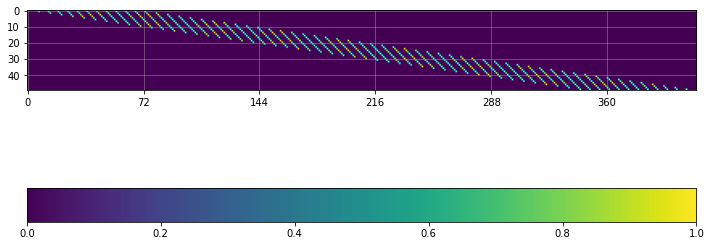

In [83]:
img_size_x = 416
img_size_y = 50
seq_length_squeeze_ratio = 1

img = np.zeros([img_size_y, img_size_x])

for yidx, seq in enumerate(seqs_idx[:img_size_y]):
    #for i in range(seq[0]//seq_length_squeeze_ratio,seq[-1]//seq_length_squeeze_ratio + 1):
    for i in seq:
        if i<img_size_x:
            img[yidx, i]=1.0

plt.figure(figsize=(12,12))
plt.xticks(ticks=list(range(0,img_size_x,seq_field)))
plt.yticks(ticks=list(range(0,img_size_y,10)))

plt.grid(alpha=0.5)
plt.imshow(img)
plt.colorbar(location='bottom')
plt.show()

figure는 50행(수직축)까지 시퀀스별 time-index(수평축)를 점으로 표시합니다.

## train, test set 구성
먼저 index를 리셋하고 시작합니다..

In [87]:

ds0.sort_values(by=dt_index, inplace=True)
ds0.reset_index(inplace=True, drop=True)
ds0=ds0[df_default_index]
print(ds0.isna().any().any())
ds0

False


,지점,year,mm,dd,hh,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생
0,통영,2017,1,2,16,5.8,249.0,12.90,16.9,0.0,0.0
1,통영,2017,1,2,17,5.9,255.0,12.85,16.9,0.0,0.0
2,통영,2017,1,2,18,6.0,261.0,12.80,16.9,0.0,0.0
3,통영,2017,1,2,19,6.6,263.0,13.00,16.9,0.0,0.0
4,통영,2017,1,2,20,7.1,268.0,13.20,16.8,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
26212,통영,2019,12,30,20,10.7,306.0,12.20,13.9,0.0,0.0
26213,통영,2019,12,30,21,11.3,298.0,11.30,13.8,0.0,0.0
26214,통영,2019,12,30,22,11.9,291.0,10.30,13.6,0.0,0.0
26215,통영,2019,12,30,23,14.9,296.0,8.90,13.5,0.0,0.0
